# Machine Learning methods on Mauna Loa CO$_2$ data

## Import required libraries and packages

In [1]:
# 1) Standard library imports
import datetime

# 2) Third party library imports
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 3) Local application/library imports

## Load input data

In [2]:
co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


## Data preprocessing

In [3]:
# Do necessary data type conversion and extract only required columns
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
co2_data.index.min(), co2_data.index.max()

(Timestamp('1958-03-29 00:00:00'), Timestamp('2001-12-29 00:00:00'))

### Visualize raw data

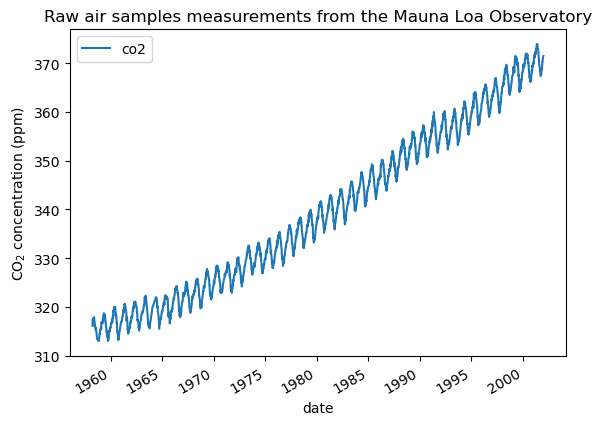

In [5]:
co2_data.plot()
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")

### Resample data to take monthly averages

In [6]:
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")

### Split Data for Cross Validation

In [7]:
RANDOM_SEED = 42
co2_train, co2_validation = train_test_split(
    co2_data, test_size=0.25, shuffle=False, random_state=RANDOM_SEED
)

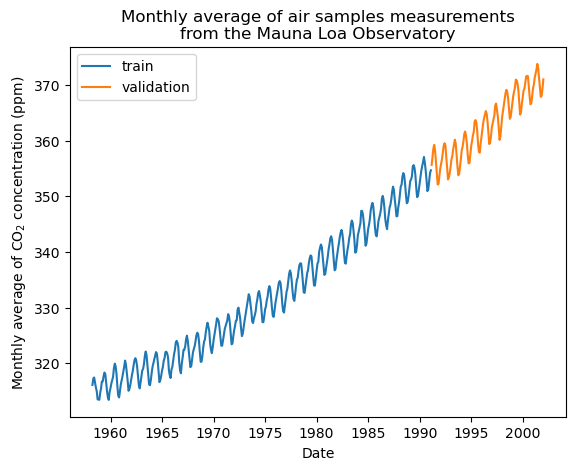

In [8]:
plt.plot(co2_train)
plt.plot(co2_validation)
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
plt.xlabel("Date")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)
plt.legend(["train", "validation"])

### Split input features and target variable

In [9]:
X = (co2_train.index.year + co2_train.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_train["co2"].to_numpy()

## Model Training

### Decision Tree

#### Predict Absolute CO2 levels

In [10]:
# Train models
regr_1 = tree.DecisionTreeRegressor(max_depth=2)
regr_2 = tree.DecisionTreeRegressor(max_depth=11)
regr_1.fit(X, y)
regr_2.fit(X, y)

DecisionTreeRegressor(max_depth=11)

In [11]:
# Make predictions on validation data
X_validation = (
    (co2_validation.index.year + co2_validation.index.month / 12)
    .to_numpy()
    .reshape(-1, 1)
)
y_validation = co2_validation["co2"].to_numpy()

y_predictions_regr_1 = regr_1.predict(X_validation)
y_predictions_regr_2 = regr_2.predict(X_validation)

In [12]:
# Calculate evaluation metrics
mse_of_regr_1 = mean_squared_error(y_validation, y_predictions_regr_1)
mse_of_regr_2 = mean_squared_error(y_validation, y_predictions_regr_2)
print(f"Validation MSE for Decision Tree with depth 2: {mse_of_regr_1:.4f}")
print(f"Validation MSE for Decision Tree with depth 11: {mse_of_regr_2:.4f}")

Validation MSE for Decision Tree with depth 2: 210.6841
Validation MSE for Decision Tree with depth 11: 96.5067


In [13]:
# Make predictions on data from 1958 to 2023
today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)

In [14]:
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

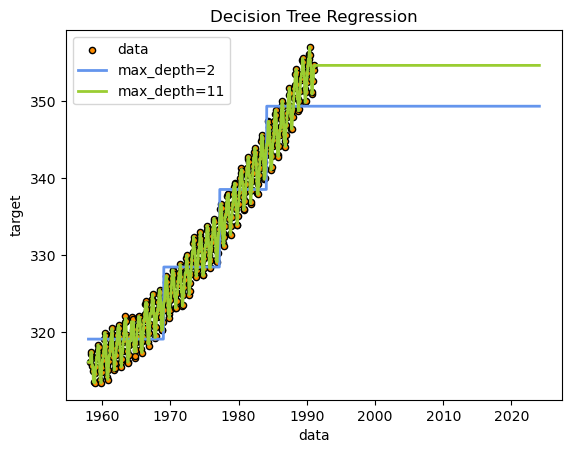

In [15]:
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(
    X_test,
    y_1,
    color="cornflowerblue",
    label=f"max_depth={regr_1.max_depth}",
    linewidth=2,
)
plt.plot(
    X_test, y_2, color="yellowgreen", label=f"max_depth={regr_2.max_depth}", linewidth=2
)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

#### Predict CO2 level differences using Decision Trees (Autoregressive Model)

In [16]:
def preprocess_data(input_data, train_window, scaler, is_test=False):
    # Take derivative
    input_data = np.concatenate([[0], np.diff(input_data)])

    # Scale values
    scaler = scaler
    if is_test:
        normalized_data = scaler.transform(input_data.reshape(-1, 1)).reshape(-1)
    else:
        normalized_data = scaler.fit_transform(input_data.reshape(-1, 1)).reshape(-1)

    # Create input-output pairs
    in_seq = []
    out_seq = []
    L = len(normalized_data)
    for i in range(L - train_window - 1):
        train_seq = normalized_data[i : i + train_window]
        train_label = normalized_data[i + train_window : i + train_window + 1]

        in_seq.append(train_seq)
        out_seq.append(train_label)
    return normalized_data, in_seq, out_seq, scaler

In [17]:
TRAIN_WINDOW = 50
standardScaler = StandardScaler()
normalized_train, X_train, y_train, scaler = preprocess_data(
    list(co2_train["co2"]), TRAIN_WINDOW, standardScaler, is_test=False
)

In [18]:
# Train models
regr_3 = tree.DecisionTreeRegressor(max_depth=2)
regr_3.fit(X_train, y_train)

regr_4 = tree.DecisionTreeRegressor(max_depth=10)
regr_4.fit(X_train, y_train)

regr_5 = tree.DecisionTreeRegressor(max_depth=25)
regr_5.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=25)

In [19]:
# Make predictions on validation data
normalized_test, X_validation, y_validation, _ = preprocess_data(
    list(co2_validation["co2"]), TRAIN_WINDOW, standardScaler, is_test=True
)

y_predictions_regr_3 = regr_3.predict(X_validation)
y_predictions_regr_4 = regr_4.predict(X_validation)
y_predictions_regr_5 = regr_5.predict(X_validation)

In [20]:
# Calculate evaluation metrics
mse_of_regr_3 = mean_squared_error(y_validation, y_predictions_regr_3)
mse_of_regr_4 = mean_squared_error(y_validation, y_predictions_regr_4)
mse_of_regr_5 = mean_squared_error(y_validation, y_predictions_regr_5)
print(f"Validation MSE for Decision Tree with depth 2: {mse_of_regr_3:.4f}")
print(f"Validation MSE for Decision Tree with depth 10: {mse_of_regr_4:.4f}")
print(f"Validation MSE for Decision Tree with depth 25: {mse_of_regr_5:.4f}")

Validation MSE for Decision Tree with depth 2: 0.1530
Validation MSE for Decision Tree with depth 10: 0.1543
Validation MSE for Decision Tree with depth 25: 0.1534


In [21]:
dates = pd.period_range("1958", "2023", freq='M').to_timestamp()

test_inputs = list(normalized_train)
fut_pred_3 = test_inputs.copy()
fut_pred_4 = test_inputs.copy()
fut_pred_5 = test_inputs.copy()
fut_pred_num = len(dates) - len(test_inputs)  # Number of predictions to make.
for i in range(fut_pred_num):
    seq = fut_pred_3[-TRAIN_WINDOW:]
    prediction = regr_3.predict([seq])
    fut_pred_3.append(prediction[0])

    seq = fut_pred_4[-TRAIN_WINDOW:]
    prediction = regr_4.predict([seq])
    fut_pred_4.append(prediction[0])

    seq = fut_pred_5[-TRAIN_WINDOW:]
    prediction = regr_5.predict([seq])
    fut_pred_5.append(prediction[0])

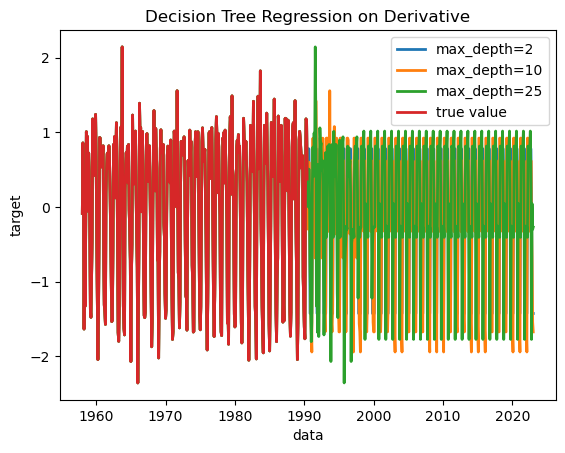

In [22]:
plt.figure()
plt.plot(dates, fut_pred_3, label=f"max_depth={regr_3.max_depth}", linewidth=2)
plt.plot(dates, fut_pred_4, label=f"max_depth={regr_4.max_depth}", linewidth=2)
plt.plot(dates, fut_pred_5, label=f"max_depth={regr_5.max_depth}", linewidth=2)
plt.plot(dates[0:len(normalized_train)], normalized_train, label=f"true value", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression on Derivative")
plt.legend()
plt.show()

#### Convert CO2 level differences to absolute CO2 levels

In [23]:
def postprocess_data(output_data, scaler, first_input):
    #unscale the output
    output = scaler.inverse_transform(np.array(output_data).reshape(-1, 1)).reshape(-1)

    output = np.cumsum(output) + first_input

    return output

decoded_3 = postprocess_data(fut_pred_3, scaler, list(co2_data["co2"])[0])
decoded_4 = postprocess_data(fut_pred_4, scaler, list(co2_data["co2"])[0])
decoded_5 = postprocess_data(fut_pred_5, scaler, list(co2_data["co2"])[0])

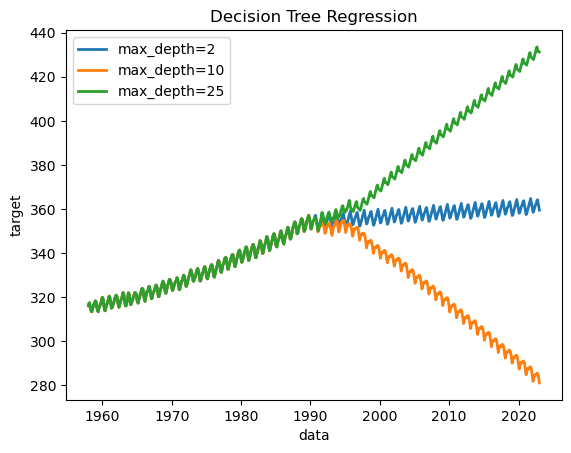

In [24]:
plt.figure()
plt.plot(dates, decoded_3, label=f"max_depth={regr_3.max_depth}", linewidth=2)
plt.plot(dates, decoded_4, label=f"max_depth={regr_4.max_depth}", linewidth=2)
plt.plot(dates, decoded_5, label=f"max_depth={regr_5.max_depth}", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### Recurrent Neural Network (RNN)

In [25]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
X_train_tensor = torch.Tensor(np.array(X_train)).to(device)
y_train_tensor = torch.Tensor(np.array(y_train)).to(device)

In [27]:
X_validation_tensor = torch.Tensor(np.array(X_validation)).to(device)
y_validation_tensor = torch.Tensor(np.array(y_validation)).to(device)

In [28]:
# Define hyperparameters
input_size = 50
hidden_size = 128
output_size = 1
n_hidden_layers = 1

In [29]:
# Define the LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=n_hidden_layers).to(device)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [30]:
# Instantiate the model, loss function, and optimizer
model = SimpleLSTM(input_size, hidden_size, output_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [31]:
# Training loop
num_epochs = 600
for epoch in range(num_epochs):
    # Forward pass
    output = model(X_train_tensor)

    # Compute the loss
    loss = loss_function(output, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/600], Loss: 0.2138
Epoch [200/600], Loss: 0.1609
Epoch [300/600], Loss: 0.1314
Epoch [400/600], Loss: 0.1117
Epoch [500/600], Loss: 0.1008
Epoch [600/600], Loss: 0.0928


In [32]:
# Make predictions on validation data
with torch.no_grad():
    y_predictions_rnn = model(X_validation_tensor)

In [33]:
# Calculate evaluation metrics
mse_of_rnn = mean_squared_error(y_validation_tensor.cpu(), y_predictions_rnn.cpu())
print(f"Validation MSE for RNN: {mse_of_rnn:.4f}")

Validation MSE for RNN: 0.1332


In [34]:
dates = pd.period_range("1958", "2023", freq='M').to_timestamp()

test_inputs = list(normalized_train)
fut_pred_num = len(dates) - len(test_inputs)  # Number of predictions to make.

In [35]:
for i in range(fut_pred_num):
  X_test = torch.Tensor(X_train[-1]).view(1, -1).to(device)
  y_test = torch.Tensor(y_train[-1]).to(device)
  
  # Forecast one month forward
  with torch.no_grad():
      y_pred = model(X_test)
  
  # Append current y value to X
  X_train.append(torch.cat((X_test[0][1:], y_test)))

  # Append prediction to the target values
  y_train.append(np.array([y_pred.item()]))

In [36]:
predictions = [np.array([0])] + [np.array([x]) for x in X_train[0]] + y_train

#### Convert CO2 level differences to absolute CO2 levels

In [37]:
decoded = postprocess_data(predictions, scaler, list(co2_train["co2"])[0])

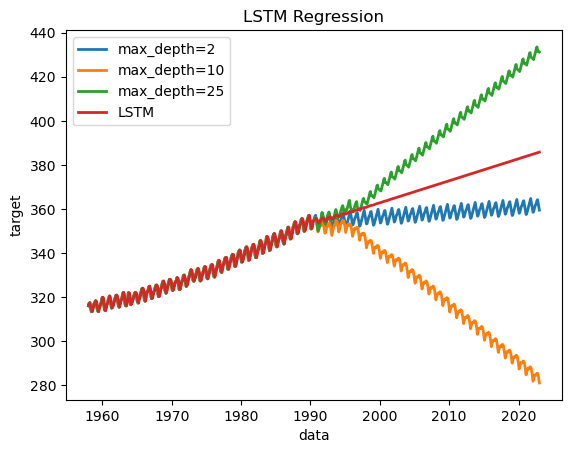

In [38]:
dates = pd.period_range("1958", "2023", freq='M').to_timestamp()
plt.figure()
plt.plot(dates, decoded_3, label=f"max_depth={regr_3.max_depth}", linewidth=2)
plt.plot(dates, decoded_4, label=f"max_depth={regr_4.max_depth}", linewidth=2)
plt.plot(dates, decoded_5, label=f"max_depth={regr_5.max_depth}", linewidth=2)
plt.plot(dates, decoded, label=f"LSTM", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("LSTM Regression")
plt.legend()
plt.show()

In [39]:
print(f"Validation MSE for Decision Tree with depth 2  : {mse_of_regr_3:.4f}")
print(f"Validation MSE for Decision Tree with depth 10 : {mse_of_regr_4:.4f}")
print(f"Validation MSE for Decision Tree with depth 25 : {mse_of_regr_5:.4f}")
print(f"Validation MSE for Recurrent Neural Network    : {mse_of_rnn:.4f}")

Validation MSE for Decision Tree with depth 2  : 0.1530
Validation MSE for Decision Tree with depth 10 : 0.1543
Validation MSE for Decision Tree with depth 25 : 0.1534
Validation MSE for Recurrent Neural Network    : 0.1332
